In [1]:
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta
#=========================
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

# Introduction

We use MLP, multiple variables ([log_ret_0, ..., log_ret_29, volume, spread, log_price_change, ...] to predict -> log_return")

## Predicting on
- log_return of price at next timestep

## Data + preprocessing

In [2]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2022-02-03"
end_date = "2022-02-04"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-02.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-03.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-04.csv


In [3]:
df.drop(["tic"], axis=1, inplace=True)
df.columns = ["Open","High","Low","Close","Volume"]

In [4]:
df.head()

,Open,High,Low,Close,Volume
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702


In [5]:
df.tail()

,Open,High,Low,Close,Volume
2022-02-04 23:59:55,41556.61,41564.16,41545.77,41545.77,2.19237
2022-02-04 23:59:56,41544.21,41553.85,41544.20,41549.21,1.27854
2022-02-04 23:59:57,41546.06,41547.44,41541.41,41545.98,2.26596
2022-02-04 23:59:58,41545.98,41552.03,41545.98,41552.02,0.22872
2022-02-04 23:59:59,41554.57,41574.25,41554.57,41574.25,5.70223


## Adding TAs

#### Volatility Indicators

In [56]:
# #bbs: EITHER 0 or 1. Very bad
# # Add bollinger band high indicator filling nans values
# df["bb_high_indicator"] = ta.volatility.bollinger_hband_indicator(
#     df["Close"], window=120, window_dev=10, fillna=True
# )
# # Add bollinger band low indicator filling nans values
# df["bb_low_indicator"] = ta.volatility.bollinger_lband_indicator(
#     df["Close"], window=120, window_dev=10, fillna=True
# )

In [57]:
#df.head(50)

#### Momentum Indicators
- Rate of change (ROC)
- Relative Strenght Index (RSI)
- Stochastic RSI (sRSI, srsi_k, srsi_d)
- True Strength Index (TSI)

In [6]:
window = 30 # a choice
# df[f"roc_{window}"] = ta.momentum.ROCIndicator(close=df["Close"], window=window).roc()

# # Relative Strength Index (RSI)
# df["momentum_rsi"] = RSIIndicator(
#     close=df["Close"], window=14, fillna=True
# ).rsi()/100 #scale 0-1

# # Stoch RSI (StochRSI)
# indicator_srsi = StochRSIIndicator(
#     close=df["Close"], window=14, smooth1=3, smooth2=3, fillna=True
# )
# df["momentum_stoch_rsi"] = indicator_srsi.stochrsi()
# df["momentum_stoch_rsi_k"] = indicator_srsi.stochrsi_k()
# df["momentum_stoch_rsi_d"] = indicator_srsi.stochrsi_d()

# TSI Indicator
df["momentum_tsi"] = TSIIndicator(
    close=df["Close"], window_slow=25, window_fast=13, fillna=True
).tsi()/100 #scale 0-1

In [7]:
df.head(50)

,Open,High,Low,Close,Volume,momentum_tsi
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,0.000000
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,-1.000000
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,-1.000000
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,-0.871596
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,-0.833150
2022-02-03 00:00:05,36898.68,36904.81,36898.68,36900.26,1.40551,-0.600366
2022-02-03 00:00:06,36899.42,36902.19,36898.71,36898.71,1.16302,-0.504129
2022-02-03 00:00:07,36898.71,36898.71,36891.64,36898.71,0.51981,-0.450333
2022-02-03 00:00:08,36898.70,36898.71,36898.70,36898.71,0.06394,-0.416051
2022-02-03 00:00:09,36898.71,36898.71,36896.06,36896.07,0.18142,-0.416555


In [8]:
df.tail()

,Open,High,Low,Close,Volume,momentum_tsi
2022-02-04 23:59:55,41556.61,41564.16,41545.77,41545.77,2.19237,0.148126
2022-02-04 23:59:56,41544.21,41553.85,41544.20,41549.21,1.27854,0.101344
2022-02-04 23:59:57,41546.06,41547.44,41541.41,41545.98,2.26596,0.048798
2022-02-04 23:59:58,41545.98,41552.03,41545.98,41552.02,0.22872,0.036460
2022-02-04 23:59:59,41554.57,41574.25,41554.57,41574.25,5.70223,0.117373


#### Volume indicators
- Money Flow Index (MFI)
- Chaikin Money Flow (CMF)
- Force Index (FI)
- Volume Weighted Average Price (VWAP)
- ~Accumulation/Distribution Index (ADI)~
- ~On-Balance Volume (OBV)~
- ~Ease of Movement (EoM, EMV)~
- ~Volume-price Trend (VPT)~
- ~Negative Volume Index (NVI)~

In [11]:
# Chaikin Money Flow
df["volume_cmf"] = ChaikinMoneyFlowIndicator(
    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
).chaikin_money_flow()

# Money Flow Index
df["volume_mfi"] = MFIIndicator(
            high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
        ).money_flow_index()/100 #norm to 0-1

# Force Index
df["volume_fi"] = ForceIndexIndicator(
    close=df["Close"], volume=df["Volume"], window=13, fillna=True
).force_index()

# Volume Weighted Average Price
df["volume_vwap"] = VolumeWeightedAveragePrice(
    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True,
    window=14,
).volume_weighted_average_price()

In [12]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,volume_vwap
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.172291,0.500000,0.000000,36902.313333
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.160627,1.000000,-0.008738,36902.319379
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.163740,0.074633,-0.381027,36901.906596
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,NaN,0.278882,0.000000,0.000000,0.000000,-0.871596,0.216383,0.049248,-0.248998,36901.715442
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,NaN,0.133146,0.000000,0.000000,0.000000,-0.833150,0.157177,0.038582,-0.443275,36901.498579
2022-02-03 00:00:05,36898.68,36904.81,36898.68,36900.26,1.40551,NaN,0.433703,0.000000,0.000000,0.000000,-0.600366,0.046164,0.502091,0.551702,36901.455574
2022-02-03 00:00:06,36899.42,36902.19,36898.71,36898.71,1.16302,NaN,0.385606,0.000000,0.000000,0.000000,-0.504129,-0.084847,0.358914,0.215362,36901.257014
2022-02-03 00:00:07,36898.71,36898.71,36891.64,36898.71,0.51981,NaN,0.385606,0.000000,0.000000,0.000000,-0.450333,-0.027345,0.318344,0.184596,36900.997098
2022-02-03 00:00:08,36898.70,36898.71,36898.70,36898.71,0.06394,NaN,0.385606,0.000000,0.000000,0.000000,-0.416051,-0.020690,0.327692,0.158225,36900.982261
2022-02-03 00:00:09,36898.71,36898.71,36896.06,36896.07,0.18142,NaN,0.312000,0.000000,0.000000,0.000000,-0.416555,-0.038228,0.315419,0.067200,36900.909429


#### Trend indicators
- Simple Moving Average (SMA) (slow only)
- Exponential Moving Average (EMA) (slow only)
- Moving Average Convergence Divergence (MACD, signal, diff)

In [13]:
# MACD
indicator_macd = MACD(
    close=df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True
)
df["trend_macd"] = indicator_macd.macd()
df["trend_macd_signal"] = indicator_macd.macd_signal()
df["trend_macd_diff"] = indicator_macd.macd_diff()

# SMAs
# df["trend_sma_fast"] = SMAIndicator(
#     close=df["Close"], window=12, fillna=True
# ).sma_indicator()
df["trend_sma_slow"] = SMAIndicator(
    close=df["Close"], window=26, fillna=True
).sma_indicator()

# EMAs
# df["trend_ema_fast"] = EMAIndicator(
#     close=df["Close"], window=12, fillna=True
# ).ema_indicator()
df["trend_ema_slow"] = EMAIndicator(
    close=df["Close"], window=26, fillna=True
).ema_indicator()

In [14]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,volume_vwap,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_slow,trend_ema_slow
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.172291,0.500000,0.000000,36902.313333,0.000000,0.000000,0.000000,36902.960000,36902.960000
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.160627,1.000000,-0.008738,36902.319379,-0.011966,-0.002393,-0.009573,36902.885000,36902.948889
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.163740,0.074633,-0.381027,36901.906596,-0.309979,-0.063910,-0.246069,36901.653333,36902.670453
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,NaN,0.278882,0.000000,0.000000,0.000000,-0.871596,0.216383,0.049248,-0.248998,36901.715442,-0.432241,-0.137576,-0.294664,36901.375000,36902.512641
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,NaN,0.133146,0.000000,0.000000,0.000000,-0.833150,0.157177,0.038582,-0.443275,36901.498579,-0.915583,-0.293178,-0.622405,36900.224000,36902.002075
2022-02-03 00:00:05,36898.68,36904.81,36898.68,36900.26,1.40551,NaN,0.433703,0.000000,0.000000,0.000000,-0.600366,0.046164,0.502091,0.551702,36901.455574,-0.913693,-0.417281,-0.496412,36900.230000,36901.873033
2022-02-03 00:00:06,36899.42,36902.19,36898.71,36898.71,1.16302,NaN,0.385606,0.000000,0.000000,0.000000,-0.504129,-0.084847,0.358914,0.215362,36901.257014,-1.025446,-0.538914,-0.486532,36900.012857,36901.638734
2022-02-03 00:00:07,36898.71,36898.71,36891.64,36898.71,0.51981,NaN,0.385606,0.000000,0.000000,0.000000,-0.450333,-0.027345,0.318344,0.184596,36900.997098,-1.101317,-0.651394,-0.449922,36899.850000,36901.421791
2022-02-03 00:00:08,36898.70,36898.71,36898.70,36898.71,0.06394,NaN,0.385606,0.000000,0.000000,0.000000,-0.416051,-0.020690,0.327692,0.158225,36900.982261,-1.148208,-0.750757,-0.397451,36899.723333,36901.220917
2022-02-03 00:00:09,36898.71,36898.71,36896.06,36896.07,0.18142,NaN,0.312000,0.000000,0.000000,0.000000,-0.416555,-0.038228,0.315419,0.067200,36900.909429,-1.382460,-0.877098,-0.505363,36899.358000,36900.839368


### use gen_feats0

In [15]:
df = gen_feats0(df)
df

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,...,volume_vwap,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_slow,trend_ema_slow,spread,upper_Shadow,lower_Shadow,trade
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,NaN,1.000000,0.000000,0.000000,0.000000,...,36902.313333,0.000000,0.000000,0.000000,36902.960000,36902.960000,11.26,4.66,0.01,6.59
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,NaN,0.000000,0.000000,0.000000,0.000000,...,36902.319379,-0.011966,-0.002393,-0.009573,36902.885000,36902.948889,0.17,0.00,0.01,-0.16
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,NaN,0.000000,0.000000,0.000000,0.000000,...,36901.906596,-0.309979,-0.063910,-0.246069,36901.653333,36902.670453,4.72,0.01,2.80,-1.91
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,NaN,0.278882,0.000000,0.000000,0.000000,...,36901.715442,-0.432241,-0.137576,-0.294664,36901.375000,36902.512641,5.01,0.00,3.66,1.35
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,NaN,0.133146,0.000000,0.000000,0.000000,...,36901.498579,-0.915583,-0.293178,-0.622405,36900.224000,36902.002075,4.92,0.01,0.00,-4.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04 23:59:55,41556.61,41564.16,41545.77,41545.77,2.19237,0.006162,0.379324,0.000000,0.305972,0.609338,...,41556.708463,2.177282,3.290843,-1.113560,41554.110000,41553.597403,18.39,7.55,0.00,-10.84
2022-02-04 23:59:56,41544.21,41553.85,41544.20,41549.21,1.27854,0.014034,0.440097,0.225454,0.075151,0.333331,...,41555.700995,1.492324,2.931139,-1.438815,41554.130385,41553.272410,9.65,4.64,0.01,5.00
2022-02-04 23:59:57,41546.06,41547.44,41541.41,41545.98,2.26596,0.021114,0.400449,0.078369,0.101274,0.160799,...,41552.822238,0.681005,2.481112,-1.800107,41553.765385,41552.732232,6.03,1.38,4.57,-0.08
2022-02-04 23:59:58,41545.98,41552.03,41545.98,41552.02,0.22872,0.033150,0.492519,0.429676,0.244500,0.140309,...,41551.723361,0.519418,2.088773,-1.569355,41553.633077,41552.679474,6.05,0.01,0.00,6.04


## Drop OHL, stationize C, and related

In [9]:
def stationize(series):
    return np.log(series / series.shift(1))

In [10]:
df.head()

,Open,High,Low,Close,Volume,momentum_tsi
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,0.000000
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,-1.000000
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,-1.000000
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,-0.871596
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,-0.833150


In [11]:
# store initial price to reconstruct it back from returns
# initialprices = {
#     "Close": df['Close'][0],
#     "volume_vwap": ,
#     "trend_sma_slow",
#     "trend_ema_slow":
# }
# the initial price is at 00:00:00
df['log_ret'] = stationize(df['Close'])
# df['log_volume_vwap_ret'] = stationize(df['volume_vwap'])
# df['log_trend_sma_slow_ret'] = stationize(df['trend_sma_slow'])
# df['log_trend_ema_slow_ret'] = stationize(df['trend_ema_slow'])

In [12]:
df.drop(["Open","High","Low", "Volume"], axis=1, inplace=True)

In [11]:
df.drop(["Open","High","Low"], axis=1, inplace=True)

In [13]:
df

,Close,momentum_tsi,log_ret
2022-02-03 00:00:00,36902.96,0.000000,NaN
2022-02-03 00:00:01,36902.81,-1.000000,-0.000004
2022-02-03 00:00:02,36899.19,-1.000000,-0.000098
2022-02-03 00:00:03,36900.54,-0.871596,0.000037
2022-02-03 00:00:04,36895.62,-0.833150,-0.000133
...,...,...,...
2022-02-04 23:59:55,41545.77,0.148126,-0.000261
2022-02-04 23:59:56,41549.21,0.101344,0.000083
2022-02-04 23:59:57,41545.98,0.048798,-0.000078
2022-02-04 23:59:58,41552.02,0.036460,0.000145


In [65]:
#df.dropna(inplace=True)

## Make Windowed dataset (using dt_feats1)

In [14]:
HORIZON = 1
WINDOW = 30

In [16]:
# Add windowed columns
for i in range(WINDOW-1): # Shift values for each step in WINDOW_SIZE
  df[f"log_ret+{i+2}"] = df["log_ret"].shift(periods=i+2)
df.head(50)

,Close,momentum_tsi,log_ret,log_ret+2,log_ret+3,log_ret+4,log_ret+5,log_ret+6,log_ret+7,log_ret+8,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2022-02-03 00:00:00,36902.96,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:01,36902.81,-1.000000,-4.064723e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:02,36899.19,-1.000000,-9.810032e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:03,36900.54,-0.871596,3.658550e-05,-4.064723e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:04,36895.62,-0.833150,-1.333403e-04,-9.810032e-05,-4.064723e-06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:05,36900.26,-0.600366,1.257523e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:06,36898.71,-0.504129,-4.200601e-05,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:07,36898.71,-0.450333,0.000000e+00,1.257523e-04,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:08,36898.71,-0.416051,0.000000e+00,-4.200601e-05,1.257523e-04,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:09,36896.07,-0.416555,-7.154978e-05,0.000000e+00,-4.200601e-05,1.257523e-04,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df.dropna().shape

(172769, 55)

In [25]:
df.shape

(172800, 55)

In [17]:
#drop non-stationized values, keeping them for later reconstruction
X = df.dropna().drop(["Close"], axis=1).astype(np.float32) 

#note, starting at :30second
X.head()

,momentum_tsi,log_ret,log_ret+2,log_ret+3,log_ret+4,log_ret+5,log_ret+6,log_ret+7,log_ret+8,log_ret+9,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2022-02-03 00:00:31,-0.326270,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,-0.000094,-0.000123,...,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037,-0.000098,-0.000004
2022-02-03 00:00:32,-0.221396,0.000299,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,-0.000094,...,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037,-0.000098
2022-02-03 00:00:33,-0.144487,-0.000010,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,...,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037
2022-02-03 00:00:34,-0.083675,0.000010,0.000299,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,...,0.000249,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133
2022-02-03 00:00:35,-0.031504,0.000027,-0.000010,0.000299,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,...,-0.000151,0.000249,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126


In [15]:
#drop non-stationized values, keeping them for later reconstruction
X = df.dropna().drop(["Close", "volume_vwap", "trend_sma_slow", "trend_ema_slow"], axis=1).astype(np.float32) 

#note, starting at :30second
X.head()

KeyError: "['volume_vwap', 'trend_sma_slow', 'trend_ema_slow'] not found in axis"

In [70]:
X.shape

(172769, 32)

In [18]:
y = df.dropna().drop(["Close"], axis=1)["log_ret"].astype(np.float32)
y.head()

2022-02-03 00:00:31    0.000000
2022-02-03 00:00:32    0.000299
2022-02-03 00:00:33   -0.000010
2022-02-03 00:00:34    0.000010
2022-02-03 00:00:35    0.000027
Freq: S, Name: log_ret, dtype: float32

In [28]:
y = df.dropna().drop(["Close", "volume_vwap", "trend_sma_slow", "trend_ema_slow"], axis=1)["log_ret"].astype(np.float32)
y.head()

2022-02-03 00:00:31    0.000000
2022-02-03 00:00:32    0.000299
2022-02-03 00:00:33   -0.000010
2022-02-03 00:00:34    0.000010
2022-02-03 00:00:35    0.000027
Freq: S, Name: log_ret, dtype: float32

In [72]:
y.shape

(172769,)

### Train val test split: (first 60% training, next 20% validation, last 20% for evaluation)

In [23]:
#train80%, validate 20%-1, test on last datapoint
split_size_1 = int(len(X) * 0.8)
X_train, y_train = X[:split_size_1], y[:split_size_1]
X_val, y_val = X[split_size_1:-1], y[split_size_1:-1]
X_test, y_test = X[-1:], y[-1:]
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(138215, 138215, 34553, 34553, 1, 1)

In [19]:
split_size_1 = int(len(X) * 0.6)
split_size_2 = int(len(X) * 0.8)
X_train, y_train = X[:split_size_1], y[:split_size_1]
X_val, y_val = X[split_size_1:split_size_2], y[split_size_1:split_size_2]
X_test, y_test = X[split_size_2:], y[split_size_2:]
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(103661, 103661, 34554, 34554, 34554, 34554)

In [20]:
X_train

,momentum_tsi,log_ret,log_ret+2,log_ret+3,log_ret+4,log_ret+5,log_ret+6,log_ret+7,log_ret+8,log_ret+9,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2022-02-03 00:00:31,-0.326270,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-0.000037,-0.000032,-0.000094,-1.228421e-04,...,1.837425e-04,-7.154977e-05,0.000000e+00,0.000000e+00,-4.200601e-05,0.000126,-0.000133,0.000037,-0.000098,-0.000004
2022-02-03 00:00:32,-0.221396,2.990162e-04,3.734214e-04,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,-9.356537e-05,...,-1.837425e-04,1.837425e-04,-7.154977e-05,0.000000e+00,0.000000e+00,-0.000042,0.000126,-0.000133,0.000037,-0.000098
2022-02-03 00:00:33,-0.144487,-9.757957e-06,0.000000e+00,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,-3.200408e-05,...,-2.594109e-04,-1.837425e-04,1.837425e-04,-7.154977e-05,0.000000e+00,0.000000,-0.000042,0.000126,-0.000133,0.000037
2022-02-03 00:00:34,-0.083675,1.002901e-05,2.990162e-04,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,-3.688733e-05,...,2.493826e-04,-2.594109e-04,-1.837425e-04,1.837425e-04,-7.154977e-05,0.000000,0.000000,-0.000042,0.000126,-0.000133
2022-02-03 00:00:35,-0.031504,2.737597e-05,-9.757957e-06,0.000299,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000e+00,...,-1.507064e-04,2.493826e-04,-2.594109e-04,-1.837425e-04,1.837425e-04,-0.000072,0.000000,0.000000,-0.000042,0.000126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04 04:48:07,-0.155324,0.000000e+00,-3.862495e-05,0.000000,0.000065,0.000000,0.000000,0.000000,0.000070,2.682600e-07,...,-2.681946e-07,0.000000e+00,-5.819653e-05,0.000000e+00,0.000000e+00,-0.000045,0.000000,0.000047,0.000000,0.000093
2022-02-04 04:48:08,-0.132133,0.000000e+00,3.835673e-05,-0.000039,0.000000,0.000065,0.000000,0.000000,0.000000,6.974515e-05,...,0.000000e+00,-2.681946e-07,0.000000e+00,-5.819653e-05,0.000000e+00,0.000000,-0.000045,0.000000,0.000047,0.000000
2022-02-04 04:48:09,-0.113169,-2.682238e-07,0.000000e+00,0.000038,-0.000039,0.000000,0.000065,0.000000,0.000000,0.000000e+00,...,-5.632104e-06,0.000000e+00,-2.681946e-07,0.000000e+00,-5.819653e-05,0.000000,0.000000,-0.000045,0.000000,0.000047
2022-02-04 04:48:10,-0.109107,-2.655451e-05,0.000000e+00,0.000000,0.000038,-0.000039,0.000000,0.000065,0.000000,0.000000e+00,...,-3.352508e-05,-5.632104e-06,0.000000e+00,-2.681946e-07,0.000000e+00,-0.000058,0.000000,0.000000,-0.000045,0.000000


## Model building and fitting

In [21]:
tf.keras.backend.clear_session()

In [22]:
# Make multivariate time series model
model_dense_multivariate = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_dense_multivariate")

# Compile
model_dense_multivariate.compile(loss="mae",
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['mse','mape','mae'])

# Fit
history = model_dense_multivariate.fit(X_train, y_train,
                                       epochs=20, #saw that 20 was good enough
                                       batch_size=128,
                                       verbose=1, # progress bar
                                       validation_data=(X_val, y_val),
                                       callbacks=[create_model_checkpoint(model_name=model_dense_multivariate.name)])

2022-02-05 21:42:34.454483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-05 21:42:34.454788: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-05 21:42:34.514617: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Pro
Epoch 1/20
 10/810 [..............................] - ETA: 4s - loss: 0.0094 - mse: 1.7314e-04 - mape: 3298166.2500 - mae: 0.0094  

2022-02-05 21:42:34.713557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


808/810 [============================>.] - ETA: 0s - loss: 8.1500e-04 - mse: 3.7265e-06 - mape: 267299.9062 - mae: 8.1500e-04

2022-02-05 21:42:39.321495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
810/810 [==============================] - 6s 7ms/step - loss: 8.1345e-04 - mse: 3.7180e-06 - mape: 266788.9062 - mae: 8.1345e-04 - val_loss: 2.1256e-04 - val_mse: 1.2762e-07 - val_mape: 72109.4219 - val_mae: 2.1256e-04
Epoch 2/20
  1/810 [..............................] - ETA: 5s - loss: 1.8315e-04 - mse: 1.0656e-07 - mape: 54192.3984 - mae: 1.8315e-04

2022-02-05 21:42:40.115465: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


810/810 [==============================] - 5s 7ms/step - loss: 2.7026e-04 - mse: 1.7464e-07 - mape: 85677.2266 - mae: 2.7026e-04 - val_loss: 1.2792e-04 - val_mse: 2.5269e-08 - val_mape: 41735.6992 - val_mae: 1.2792e-04
Epoch 3/20
810/810 [==============================] - 5s 6ms/step - loss: 1.7926e-04 - mse: 7.6542e-08 - mape: 54942.0195 - mae: 1.7926e-04 - val_loss: 2.2752e-04 - val_mse: 7.2152e-08 - val_mape: 80147.0234 - val_mae: 2.2752e-04
Epoch 4/20
810/810 [==============================] - 5s 6ms/step - loss: 1.4646e-04 - mse: 4.8531e-08 - mape: 43578.9727 - mae: 1.4646e-04 - val_loss: 1.6598e-04 - val_mse: 3.8129e-08 - val_mape: 54232.0664 - val_mae: 1.6598e-04
Epoch 5/20
810/810 [==============================] - 5s 7ms/step - loss: 1.0685e-04 - mse: 2.4809e-08 - mape: 29076.3223 - mae: 1.0685e-04 - val_loss: 6.0018e-05 - val_mse: 8.7421e-09 - val_mape: 11756.3779 - val_mae: 6.0018e-05
Epoch 6/20
810/810 [==============================] - 5s 6ms/step - loss: 1.0225e-04 - mse:

## Examining Histories

In [19]:
import matplotlib.pyplot as plt

In [20]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mape', 'mae', 'val_loss', 'val_mse', 'val_mape', 'val_mae'])


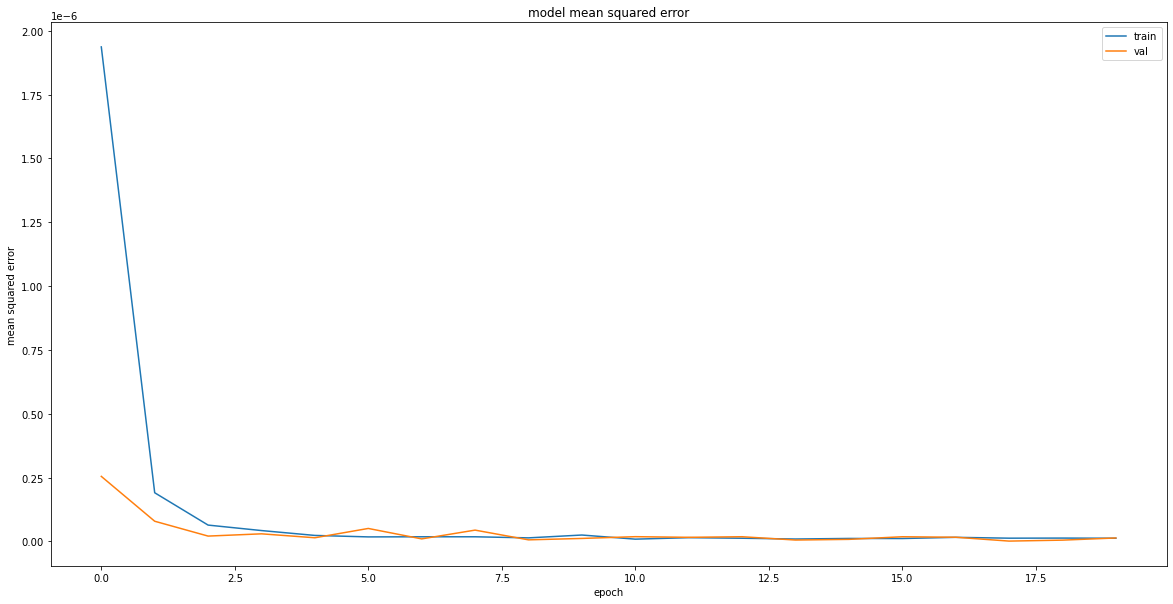

In [21]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

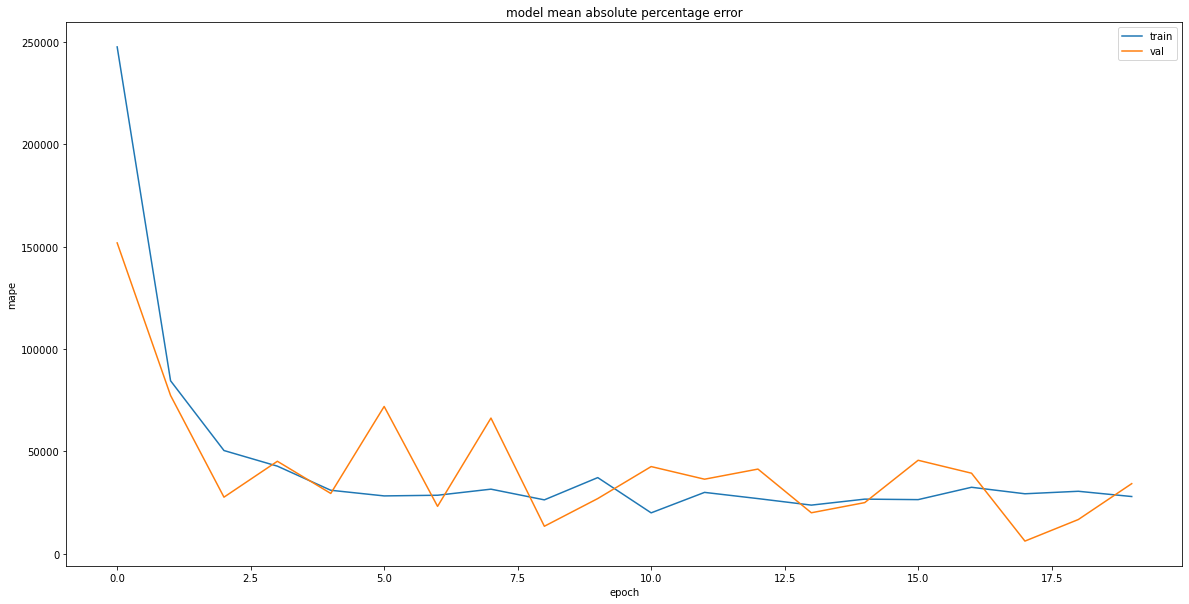

In [22]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### insights
This model learns quite well 20 epochs in

## Evaluating model on new (unseen data)
should be the %age off of predicting the horizon price

In [23]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_dense_multivariate")
loss = model_6.evaluate(X_test, y_test)

  37/1080 [>.............................] - ETA: 4s - loss: 4.5460e-05 - mse: 6.9617e-09 - mape: 1859.0469 - mae: 4.5460e-05

2022-02-05 21:06:38.842946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1080/1080 [==============================] - 5s 4ms/step - loss: 3.3862e-05 - mse: 4.0608e-09 - mape: 4445.4326 - mae: 3.3862e-05


In [24]:
# percentage
y_pred = model_6.predict(X_test)

2022-02-05 21:06:46.418010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [25]:
type(y_pred)

numpy.ndarray

In [26]:
y_pred

array([[ 3.3802837e-05],
       [ 2.6634621e-05],
       [-5.2697611e-05],
       ...,
       [-5.8745125e-05],
       [ 8.3885359e-05],
       [ 3.3144513e-04]], dtype=float32)

In [27]:
y_test = np.array(y_test)

In [28]:
type(y_test)

numpy.ndarray

In [29]:
y_test

array([ 5.7333345e-05,  5.2818090e-05, -5.3348940e-05, ...,
       -7.7742166e-05,  1.4537053e-04,  5.3484901e-04], dtype=float32)

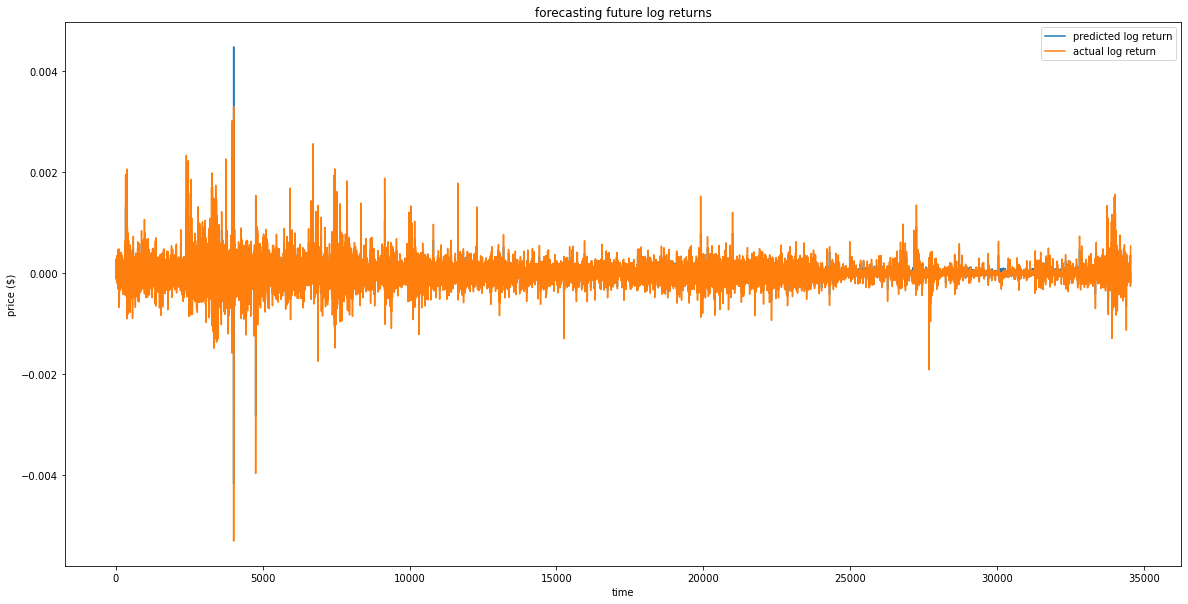

In [30]:
plt.plot(y_pred, label="predicted log return")
plt.plot(y_test, label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

## Go from log returns back to price

initial price should be price at X_test.timestamp-1

In [31]:
p_0 = X_test

In [32]:
# 1 step back as p_initial
p_0_time = X_test.index[0] - pd.Timedelta(X_test.index[0].freq)

In [33]:
p_0_test = df.loc[p_0_time]['Close']

### The price should be initial_price * exp(log_ret.cumsum())

In [34]:
tot_return_pct = y_pred.cumsum()
tot_return_pct

array([ 3.3802837e-05,  6.0437458e-05,  7.7398472e-06, ...,
       -1.9946715e-01, -1.9938327e-01, -1.9905183e-01], dtype=float32)

In [35]:
y_pred_prices = p_0_test*np.exp(y_pred.cumsum())

In [36]:
y_actual_prices = p_0_test*np.exp(y_test.cumsum())

In [37]:
len(y_pred_prices), len(y_actual_prices)

(34554, 34554)

In [38]:
y_pred_prices[:500]

array([37674.605, 37675.605, 37673.62 , 37673.04 , 37679.11 , 37675.78 ,
       37675.84 , 37675.55 , 37674.434, 37672.16 , 37671.63 , 37670.69 ,
       37672.613, 37674.137, 37674.848, 37673.504, 37672.79 , 37670.34 ,
       37667.32 , 37664.664, 37663.74 , 37658.72 , 37662.57 , 37659.668,
       37659.566, 37660.39 , 37660.05 , 37660.973, 37660.59 , 37660.11 ,
       37661.61 , 37661.363, 37660.582, 37657.91 , 37664.63 , 37673.04 ,
       37675.24 , 37673.395, 37670.75 , 37669.58 , 37669.348, 37669.797,
       37675.94 , 37676.418, 37677.95 , 37676.562, 37675.1  , 37677.07 ,
       37673.105, 37674.668, 37673.78 , 37672.36 , 37665.1  , 37663.61 ,
       37663.75 , 37663.293, 37664.074, 37672.6  , 37682.7  , 37683.285,
       37683.355, 37683.406, 37676.297, 37680.49 , 37670.47 , 37669.2  ,
       37668.426, 37665.63 , 37669.09 , 37668.043, 37665.336, 37672.32 ,
       37678.25 , 37679.844, 37679.06 , 37679.543, 37687.24 , 37691.332,
       37685.023, 37688.816, 37688.96 , 37684.32 , 

In [39]:
y_actual_prices

array([37675.49 , 37677.477, 37675.47 , ..., 41545.98 , 41552.016,
       41574.246], dtype=float32)

In [40]:
df['Close'][-10:]

2022-02-04 23:59:50    41559.41
2022-02-04 23:59:51    41559.41
2022-02-04 23:59:52    41560.00
2022-02-04 23:59:53    41560.00
2022-02-04 23:59:54    41556.62
2022-02-04 23:59:55    41545.77
2022-02-04 23:59:56    41549.21
2022-02-04 23:59:57    41545.98
2022-02-04 23:59:58    41552.02
2022-02-04 23:59:59    41574.25
Freq: S, Name: Close, dtype: float64

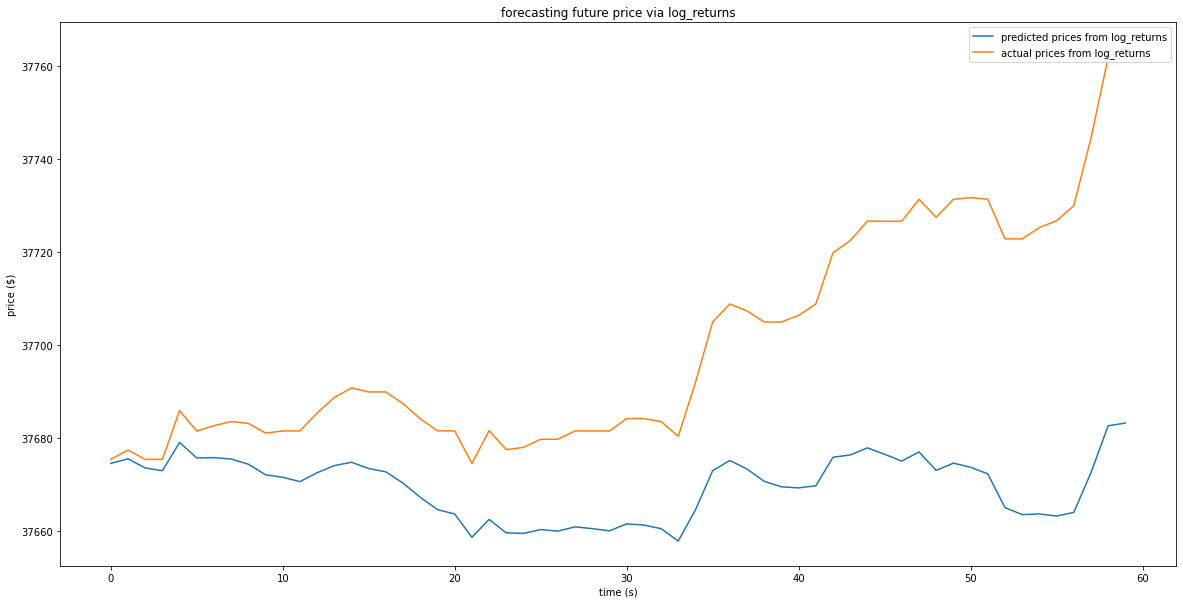

In [41]:
plt.plot(y_pred_prices[:60], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:60], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

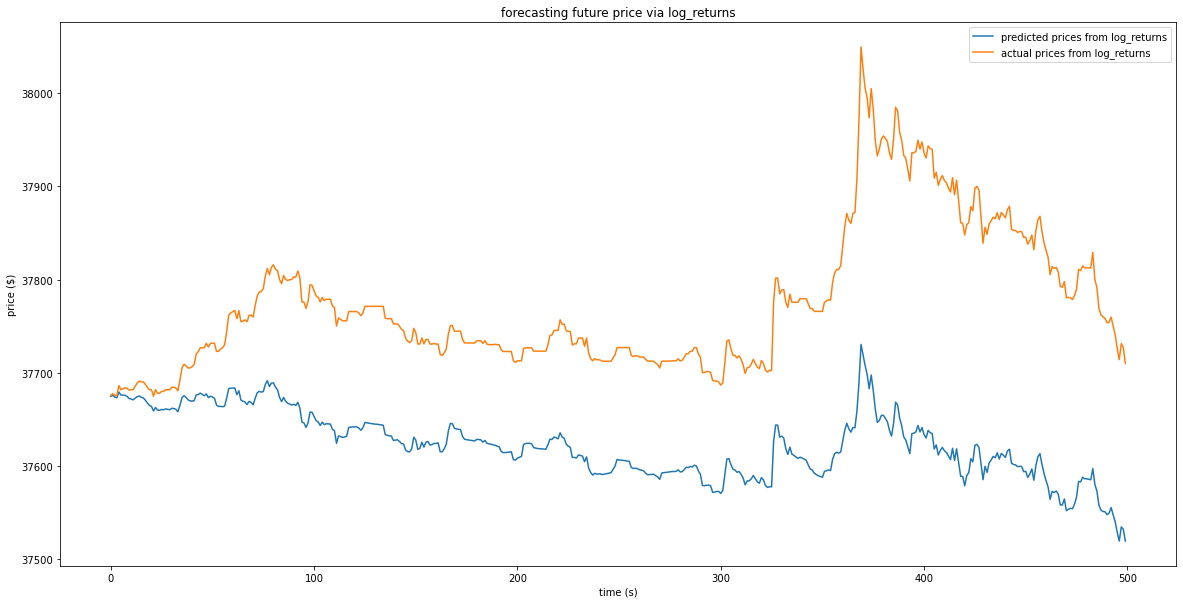

In [42]:
plt.plot(y_pred_prices[:500], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:500], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

### Observation: is okay for the first bit of data beyond train/val set, approx 50seconds, afterwards it flies!

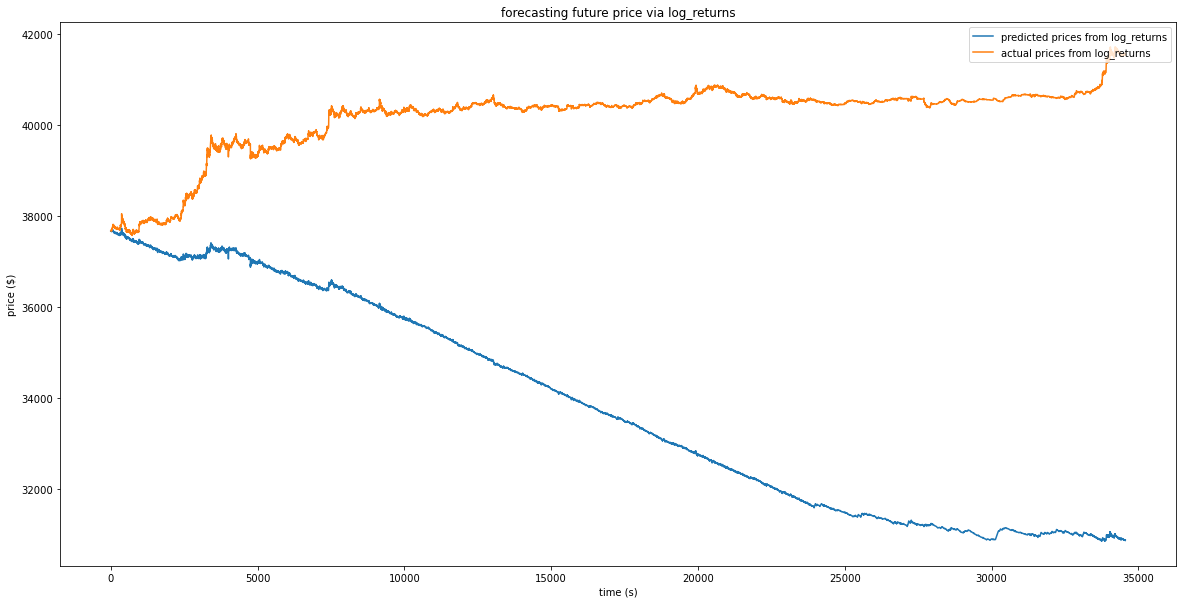

In [43]:
# for example, on the whole testing set
plt.plot(y_pred_prices, label="predicted prices from log_returns")
plt.plot(y_actual_prices, label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()